In [1]:
# Importing the required libraries

import math
import heapq
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

In [2]:
# Loading the data

DATA_DIR = Path().cwd().parent / "data"
DATA_URL = DATA_DIR / "moons.csv"

In [3]:
df = pd.read_csv(DATA_URL)
df.head()

,Xmoons_X1,Xmoons_X2
0,-0.378142,0.940750
1,0.933566,0.153805
2,2.048309,0.498172
3,0.947891,0.162473
4,2.000739,0.183700


In [4]:
scaler = MinMaxScaler()

df = pd.DataFrame(data=scaler.fit_transform(df), columns=["x", "y"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1500 non-null   float64
 1   y       1500 non-null   float64
dtypes: float64(2)
memory usage: 23.6 KB


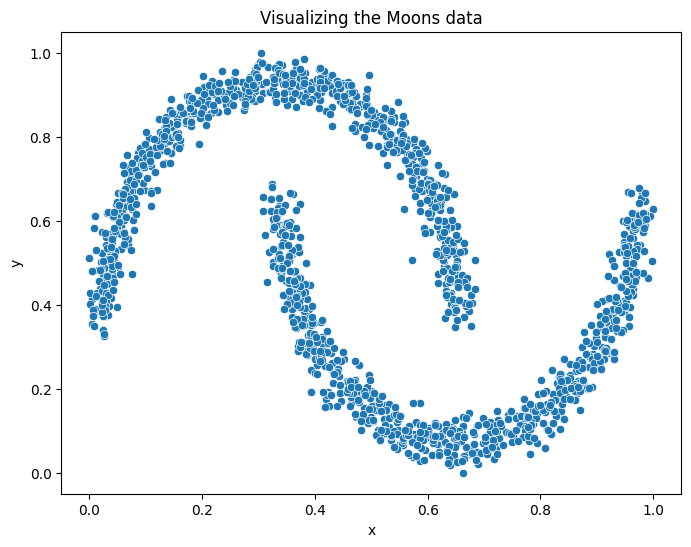

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y")
plt.title("Visualizing the Moons data")
plt.show()

In [10]:
class HierarchialClustering:

    def __init__(self, linkage = "single"):
        self.linkage = linkage

        if linkage == "ward":
            self.linkage_distances = dict()

    
    def get_distances(self, a: int, b: int) -> float:
        if a < self.n and b < self.n:
            dist = self.distance_matrix[a, b]
        else:
            if (a, b) in self.linkage_distances:
                dist = self.linkage_distances[(a, b)]
            elif (b, a) in self.linkage_distances:
                dist = self.linkage_distances[(b, a)]
            else:
                dist = np.inf

        return dist


    def ward_linkage(self, s: int, t: int, v: int) -> float:        
        T = len(self.IDS[v]) + len(self.IDS[s]) + len(self.IDS[t])

        s_and_t_dist = self.get_distances(s, t)
        v_and_s_dist = self.get_distances(s, v)
        v_and_t_dist = self.get_distances(t, v)
        
        v_and_s = ((len(self.IDS[v]) + len(self.IDS[s])) / T) * math.pow(v_and_s_dist, 2)
        v_and_t = ((len(self.IDS[v]) + len(self.IDS[t])) / T) * math.pow(v_and_t_dist, 2)
        s_and_t = ((len(self.IDS[s]) + len(self.IDS[t])) / T) * math.pow(s_and_t_dist, 2)

        dist = math.sqrt(v_and_s + v_and_t + s_and_t)

        self.linkage_distances[(self.cluster_id, v)] = dist

        return dist


    def single_linkage(self, u: int, v: int) -> float:        
        u_pts = self.X[list(self.IDS[u])]
        v_pts = self.X[list(self.IDS[v])]

        dist = np.min(cdist(u_pts, v_pts))

        return dist


    def complete_linkage(self, u: int, v: int) -> float:        
        u_pts = self.X[list(self.IDS[u])]
        v_pts = self.X[list(self.IDS[v])]

        dist = np.max(cdist(u_pts, v_pts))

        return dist

    
    def fit(self, X: np.array):
        self.n, self.d = X.shape

        self.X = X
        
        self.C = {i: i for i in range(self.n)}
        self.IDS = {i: set([i]) for i in range(self.n)}

        self.cluster_id = self.n

        self.distance_matrix = cdist(X, X)

        pq = []
        
        for i in range(self.n):
            for j in range(self.n):
                if i != j:
                    heapq.heappush(pq, (self.distance_matrix[i, j], (i, j)))

        Z = np.empty(shape=(self.n - 1, 4))
        labels = np.empty(shape=(self.n))
        
        while len(pq) > 0:
            dist, (s, t) = heapq.heappop(pq)

            if self.C[s] != s or self.C[t] != t:
                continue                    
            
            self.IDS[self.cluster_id] = self.IDS[s].union(self.IDS[t])
            self.C[s] = self.cluster_id
            self.C[t] = self.cluster_id

            self.C[self.cluster_id] = self.cluster_id

            idx = self.cluster_id - self.n

            Z[idx, 0] = s
            Z[idx, 1] = t
            Z[idx, 2] = dist
            Z[idx, 3] = len(self.IDS[self.cluster_id])

            for v in range(self.cluster_id):
                if v not in self.IDS[self.cluster_id]:
                    if self.linkage == "ward":
                        heapq.heappush(pq, (self.ward_linkage(s, t, v), (self.cluster_id, v)))
                    elif self.linkage == "single":
                        heapq.heappush(pq, (self.single_linkage(self.cluster_id, v), (self.cluster_id, v)))
                    else:
                        heapq.heappush(pq, (self.complete_linkage(self.cluster_id, v), (self.cluster_id, v)))

            self.cluster_id += 1

        
        plt.figure(figsize=(8, 6))
        dn = dendrogram(Z)
        plt.title("Hierarchical Clustering Dendrogram")
        plt.show()


        return Z

    
    def predict(self, n_clusters: int) -> np.array:
        labels = np.empty(shape=(self.n), dtype=int)

        for i in range(1, n_clusters + 1):
            idx = list(self.IDS[self.cluster_id - i - 1])
            labels[idx] = i - 1

        return labels

In [11]:
hc = HierarchialClustering(linkage="single")

In [12]:
X = df[["x", "y"]].values
Z = hc.fit(X)

X shape = (1500, 2)
Cluster ID: 1500
Cluster ID: 1501
Cluster ID: 1502
Cluster ID: 1503
Cluster ID: 1504
Cluster ID: 1505
Cluster ID: 1506
Cluster ID: 1507
Cluster ID: 1508
Cluster ID: 1509
Cluster ID: 1510
Cluster ID: 1511
Cluster ID: 1512
Cluster ID: 1513
Cluster ID: 1514
Cluster ID: 1515
Cluster ID: 1516
Cluster ID: 1517
Cluster ID: 1518
Cluster ID: 1519
Cluster ID: 1520
Cluster ID: 1521
Cluster ID: 1522
Cluster ID: 1523
Cluster ID: 1524
Cluster ID: 1525
Cluster ID: 1526
Cluster ID: 1527
Cluster ID: 1528
Cluster ID: 1529
Cluster ID: 1530
Cluster ID: 1531
Cluster ID: 1532
Cluster ID: 1533
Cluster ID: 1534
Cluster ID: 1535
Cluster ID: 1536
Cluster ID: 1537
Cluster ID: 1538
Cluster ID: 1539
Cluster ID: 1540
Cluster ID: 1541
Cluster ID: 1542
Cluster ID: 1543
Cluster ID: 1544
Cluster ID: 1545
Cluster ID: 1546
Cluster ID: 1547
Cluster ID: 1548
Cluster ID: 1549
Cluster ID: 1550
Cluster ID: 1551
Cluster ID: 1552
Cluster ID: 1553
Cluster ID: 1554
Cluster ID: 1555
Cluster ID: 1556
Cluster ID:

In [13]:
np.set_printoptions(suppress=True)
Z

array([[ 579.        ,  748.        ,    0.00028326,    2.        ],
       [ 380.        ,  951.        ,    0.0003655 ,    2.        ],
       [ 852.        , 1163.        ,    0.00039019,    2.        ],
       ...,
       [2992.        , 2785.        ,    0.03293782,  750.        ],
       [2995.        , 1372.        ,    0.04469302,  750.        ],
       [2997.        , 2996.        ,    0.16139699, 1500.        ]])

In [ ]:
Z.shape

In [21]:
df["two_clusters"] = hc.predict(n_clusters=2)

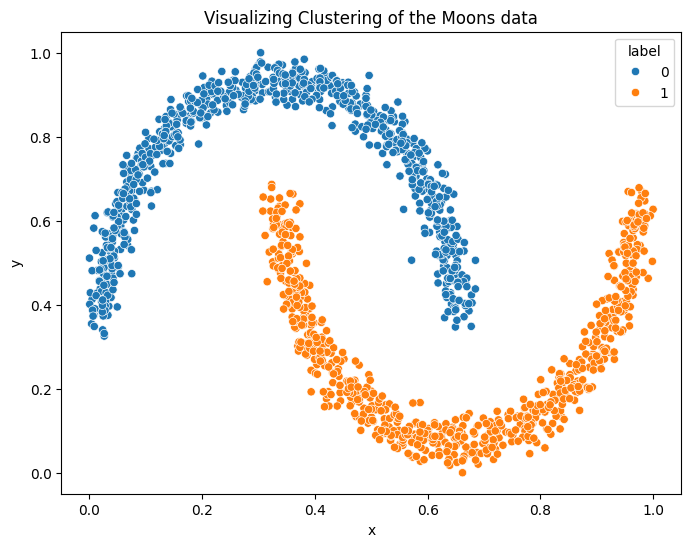

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue='two_clusters')
plt.title("Visualizing Clustering of the Moons data")
plt.show()

In [ ]:
df["five_clusters"] = hc.predict(n_clusters=5)

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue='five_clusters')
plt.title("Visualizing Clustering of the Moons data")
plt.show()

In [ ]:
df["ten_clusters"] = hc.predict(n_clusters=10)

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue='ten_clusters')
plt.title("Visualizing Clustering of the Moons data")
plt.show()

In [ ]:
hc = HierarchialClustering(linkage="complete")

In [ ]:
df["two_clusters"] = hc.predict(n_clusters=2)

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue='two_clusters')
plt.title("Visualizing Clustering of the Moons data")
plt.show()

In [ ]:
df["five_clusters"] = hc.predict(n_clusters=5)

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue='five_clusters')
plt.title("Visualizing Clustering of the Moons data")
plt.show()

In [ ]:
df["ten_clusters"] = hc.predict(n_clusters=10)

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue='ten_clusters')
plt.title("Visualizing Clustering of the Moons data")
plt.show()

In [ ]:
hc = HierarchialClustering(linkage="ward")